## ABSO and TEA-COSI microstructure data
Rippeth et al. 2015
https://www.nature.com/articles/ngeo2350#citeas

In [225]:
import netCDF4 as nc
from netCDF4 import Dataset
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# gsw oceanic toolbox: http://www.teos-10.org/pubs/Getting_Started.pdf
import gsw
from scipy.io import loadmat
import os
import sys
sys.path.append('../..')
from src.data.functions import safe_log
from src.utils.directories import get_parent_directory

In [226]:
parent_dir = get_parent_directory()
mat_nc = os.path.join(parent_dir, "data/external/Microstructure/arctic_microstructure.mat")
mat = loadmat(mat_nc)

## each profiler had a two probes. Take mean? See how different they are? take one?

In [227]:
# maintain the 350 profiles
distinct_profiles = mat["vmp"][0,:]

In [228]:
# extract each component in 351,1 shape, so data array for each 
## time in dday, year is 2007
time = np.array([array[1].squeeze() for array in distinct_profiles], dtype=object)
T = np.array([array[10].squeeze() for array in distinct_profiles], dtype=object)
S = np.array([array[11].squeeze()  for array in distinct_profiles], dtype=object)
density = np.array([array[12].squeeze() for array in distinct_profiles], dtype=object)
depth = np.array([array[8].squeeze() for array in distinct_profiles], dtype=object)
N2 = np.array([array[13].squeeze() for array in distinct_profiles], dtype=object)
eps = np.array([array[14].squeeze() for array in distinct_profiles], dtype=object)
eps2 = np.array([array[15].squeeze() for array in distinct_profiles], dtype=object)
k = np.array([array[16].squeeze() for array in distinct_profiles], dtype=object)

In [229]:
# year is always 2007 so create array of length of the profiles
year = np.full((len(distinct_profiles),), 2007)

In [230]:
length_dict = {i: len(array) for i, array in enumerate(T)}
depth_len = max(length_dict.values())

In [231]:
# repeat longitude dimension for every thing
lon = np.array([array[2].repeat(length_dict[i]).squeeze() for i, array in enumerate(distinct_profiles)], dtype=object)
lat = np.array([array[3].repeat(length_dict[i]).squeeze() for i, array in enumerate(distinct_profiles)], dtype=object)
lon_profiles = np.array([array[2].squeeze() for array in distinct_profiles], dtype=object)
lat_profiles = np.array([array[3].squeeze() for array in distinct_profiles], dtype=object)

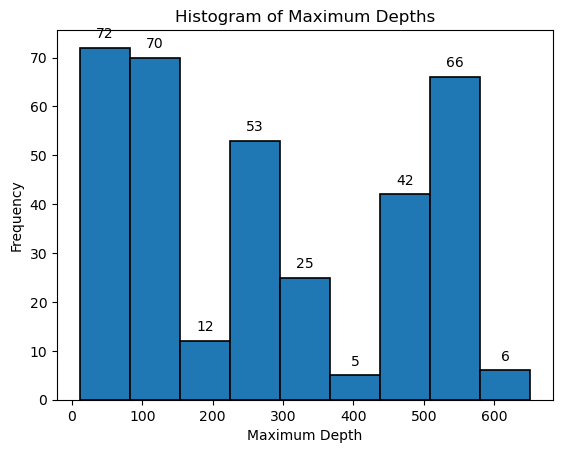

In [232]:
# take the max depth for every profile
max_depths = [max(arr) for arr in depth]

fig, ax = plt.subplots()
n, bins, patches = plt.hist(max_depths, bins=9, edgecolor='black', linewidth=1.2)
# Add labels and title
plt.xlabel('Maximum Depth')
plt.ylabel('Frequency')
plt.title('Histogram of Maximum Depths')

# Add text labels to each bin
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width() / 2
    y = patches[i].get_height()
    ax.annotate(str(int(y)), xy=(x, y), xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')

# Show the plot
plt.show()

## Convert to xr dataset
two dimensions are profile and depth

In [9]:
def fillnan(dataarray):
    for i, array in enumerate(dataarray):
        if (len(array)) < length_dict[i]:
            new_array = np.full((1, length_dict[i]), np.nan)
            dataarray[i] = new_array
    return dataarray

In [10]:
density = fillnan(density)
N2 = fillnan(N2)
eps = fillnan(eps)
k = fillnan(k)

In [11]:
# fill the empty sub-arrays with NaNs
time = np.array([arr if arr.size != 0 else np.array(np.nan) for arr in time], dtype=object)

In [25]:
def take_mean(array, depth_array, num, digitized, bin_edges):
    #if len(array[num]) < depth_array:
    #    fillnan(array[num])
    mean = [array[num][digitized == i].mean() for i in range(1, len(bin_edges))]
    return mean

In [13]:
# Create empty dictionary to store DataArrays
data_vars = {}

n = 1 # depth_interval
bin_edges = np.arange(0, n*70, n)

# loop through all arrays and bin them
for num, arr in enumerate(depth):
    digitized = np.digitize(arr, bin_edges)
    # start counting at one so the 0-1 interval fits with the 0m depth
    T_mean= take_mean(T, arr, num, digitized, bin_edges)
    S_mean= take_mean(S, arr, num, digitized, bin_edges)
    
    #density_mean= take_mean(density, arr, num, digitized, bin_edges)
    #N2_mean= take_mean(N2, arr, num, digitized, bin_edges)
    eps_mean = take_mean(eps, arr, num, digitized, bin_edges)
    #k_mean= take_mean(k, arr, num, digitized, bin_edges)
    
    # create a new variable for each profile that contains both T and S data
    data_vars[f"profile_{num}"] = xr.Dataset({
        "T": xr.DataArray(T_mean, dims=("depth",), coords={"depth": bin_edges[:-1]}),
        "S": xr.DataArray(S_mean, dims=("depth",), coords={"depth": bin_edges[:-1]}),
        #"density": xr.DataArray(density_mean, dims=("depth",), coords={"depth": bin_edges[:-1]}),
        #"N2": xr.DataArray(N2_mean, dims=("depth",), coords={"depth": bin_edges[:-1]}),
        "eps": xr.DataArray(eps_mean, dims=("depth",), coords={"depth": bin_edges[:-1]}),
        #"k": xr.DataArray(k_mean, dims=("depth",), coords={"depth": bin_edges[:-1]}),
    })
    
    data_vars[f"profile_{num}"].coords["longitude"] = lon_profiles[num]
    data_vars[f"profile_{num}"].coords["latitude"] = lat_profiles[num]
    data_vars[f"profile_{num}"].coords["year"] = year[num]
    data_vars[f"profile_{num}"].coords["time"] = time[num]

# Combine all profiles into a single dataset
ds = xr.combine_nested(list(data_vars.values()), concat_dim="profile")

/var/folders/nn/7hvkdmmn3c15btn2lqvyf2800000gq/T/ipykernel_47912/3638461788.py:4: RuntimeWarning: Mean of empty slice.
  mean = [array[num][digitized == i].mean() for i in range(1, len(bin_edges))]
/Users/Lisanne/opt/anaconda3/envs/gtc/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# 351 profiles all with different depths. 
# Resample all depths and nd arrays to all have the same depth dimension.

## manually add ice cover from Rippeth et al (2015)
https://static-content.springer.com/esm/art%3A10.1038%2Fngeo2350/MediaObjects/41561_2015_BFngeo2350_MOESM286_ESM.pdf

Canada basin
min_lon = -180
max_lon = -120
can_time = pd.to_datetime('2012-08-15')
can_ice = 0

- Severnaya Zemla
min_lon = 60
max_lon = 120
- Laptev Sea
min_lon = 120
max_lon = 125
- East siberia
min_lon = 125
max_lon = 180

ALl above are same:
min_lon = 60
max_lon = 180
eurasian_time = pd.to_datetime('2008-10-15')
eurasian_ice = 100

Svalbard
min_lon = 5
max_lon = 60
sval_time = pd.to_datetime('2013-07-15')
sval_ice = .8

Abso cruise
min_lon = -120
max_lon = 5
asbo_time = pd.to_datetime('2007-08-15')
asbo_ice = 0

In [233]:
# Define the longitude ranges and corresponding time and ice cover values
time_ice_ranges = {
    (-180, -120): {'time': pd.to_datetime('2012-08-15'), 'ice_cover': 0},  # Canada basin
    (60, 120): {'time': pd.to_datetime('2012-08-15'), 'ice_cover': 0},  # Severnaya Zemla
    (120, 125): {'time': pd.to_datetime('2012-08-15'), 'ice_cover': 0},  # Laptev Sea
    (125, 180): {'time': pd.to_datetime('2012-08-15'), 'ice_cover': 0},  # East Siberia
    (60, 180): {'time': pd.to_datetime('2008-10-15'), 'ice_cover': 100},  # Eurasian Arctic
    (5, 60): {'time': pd.to_datetime('2013-07-15'), 'ice_cover': 0.8},  # Svalbard
    (-120, 5): {'time': pd.to_datetime('2007-08-15'), 'ice_cover': 0}  # Abso cruise
}

In [234]:
depths = depth

In [235]:
time_ice_ranges = {
    (-180, -120): {'time': pd.to_datetime('2012-08-15'), 'ice_cover': 0, 'cruise': 'TEA_COSI'},  # Canada basin
    (60, 120): {'time': pd.to_datetime('2012-08-15'), 'ice_cover': 0, 'cruise': 'TEA_COSI'},  # Severnaya Zemla
    (120, 125): {'time': pd.to_datetime('2012-08-15'), 'ice_cover': 0, 'cruise': 'TEA_COSI'},  # Laptev Sea
    (125, 180): {'time': pd.to_datetime('2012-08-15'), 'ice_cover': 0, 'cruise': 'TEA_COSI'},  # East Siberia
    (60, 180): {'time': pd.to_datetime('2008-10-15'), 'ice_cover': 100, 'cruise': 'TEA_COSI'},  # Eurasian Arctic
    (5, 60): {'time': pd.to_datetime('2013-07-15'), 'ice_cover': 0.8, 'cruise': 'TEA_COSI'},  # Svalbard
    (-120, 5): {'time': pd.to_datetime('2007-08-15'), 'ice_cover': 0, 'cruise': 'ABSO'}  # Abso cruise
}

datasets = []

for num, arr in enumerate(depths):
    depth_range = np.arange(0, 800)
    
    rounded_depth = np.floor(arr)
    arr_T = T[num]
    arr_S = S[num]
    arr_eps = eps[num]

    min_depth = int(np.min(rounded_depth))
    max_depth = int(np.max(rounded_depth))
    
    depth_range_T = np.arange(min_depth, max_depth+1)
    depth_range_S = np.arange(min_depth, max_depth+1)
    depth_range_eps = np.arange(min_depth, max_depth+1)

    # Fill up filled_T with values from T where depth array is not empty
    filled_T = np.full_like(depth_range, np.nan, dtype=float)
    filled_S = np.full_like(depth_range, np.nan, dtype=float)
    filled_eps = np.full_like(depth_range, np.nan, dtype=float)

    indices = rounded_depth.astype(int)

    # Fill up filled_T, filled_S, and filled_eps with values from their respective arrays where depth array is not empty
    filled_T[indices] = arr_T
    filled_S[indices] = arr_S
    filled_eps[indices] = arr_eps
    
    # Combine filled T, S, and eps into a dataset along the dimension of depth_range_T
    dataset = xr.Dataset(
        {
            'T': (['depth'], filled_T),
            'S': (['depth'], filled_S),
            'eps': (['depth'], filled_eps),
        },
        #coords={'coor_depth': depth_range_T},
    )

    # Find the corresponding time and ice cover for the longitude profile
    lon = lon_profiles[num]
    for lon_range, values in time_ice_ranges.items():
        min_lon, max_lon = lon_range
        if min_lon <= lon <= max_lon:
            dataset['time'] = values['time']
            dataset['sea_ice_concentration'] = values['ice_cover']
            dataset['cruise'] = values['cruise']
            break

    dataset.coords["longitude"] = lon
    dataset.coords["latitude"] = lat_profiles[num]
    

    datasets.append(dataset)

# Combine all datasets along the depth dimension
combined_dataset = xr.concat(datasets, dim='profile')

print(combined_dataset)


<xarray.Dataset>
Dimensions:                (profile: 351, depth: 800)
Coordinates:
    longitude              (profile) float64 125.9 125.9 125.9 ... 18.66 9.366
    latitude               (profile) float64 76.73 76.73 76.73 ... 75.51 76.75
Dimensions without coordinates: profile, depth
Data variables:
    T                      (profile, depth) float64 nan nan nan ... nan nan nan
    S                      (profile, depth) float64 nan nan nan ... nan nan nan
    eps                    (profile, depth) float64 nan nan nan ... nan nan nan
    time                   (profile) datetime64[ns] 2012-08-15 ... 2013-07-15
    sea_ice_concentration  (profile) float64 0.0 0.0 0.0 0.0 ... 0.8 0.8 0.8 0.8
    cruise                 (profile) <U8 'TEA_COSI' 'TEA_COSI' ... 'TEA_COSI'


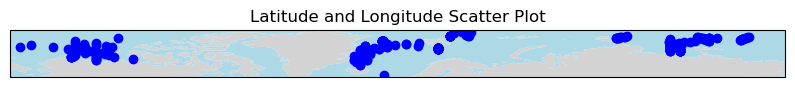

In [236]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Assuming your dataset is stored in a DataFrame called 'data'
latitude = ds['latitude']
longitude = ds['longitude']

# Create a figure and axes with a specific projection
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Add land and ocean features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot latitude and longitude data as scatter points
ax.scatter(longitude, latitude, color='blue', marker='o', transform=ccrs.PlateCarree())

# Set plot title and labels
plt.title('Latitude and Longitude Scatter Plot')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

## Some plots

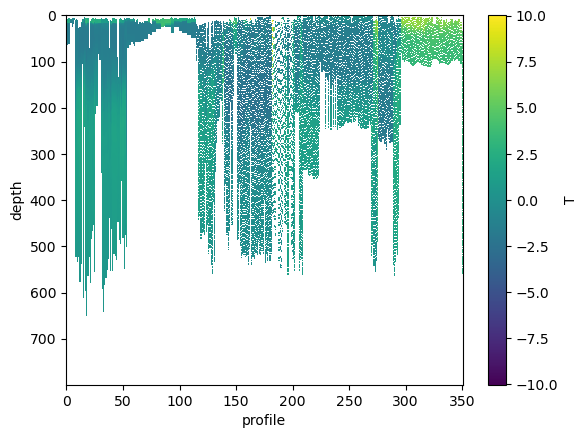

In [237]:
# create a transposed dataset
ds_transposed = ds.transpose("depth", "profile")

# plot the eps variable with transposed coordinates
ds_transposed.T.plot(cmap='viridis')

# add axis labels
plt.xlabel("profile")
plt.ylabel("depth")
plt.gca().invert_yaxis()

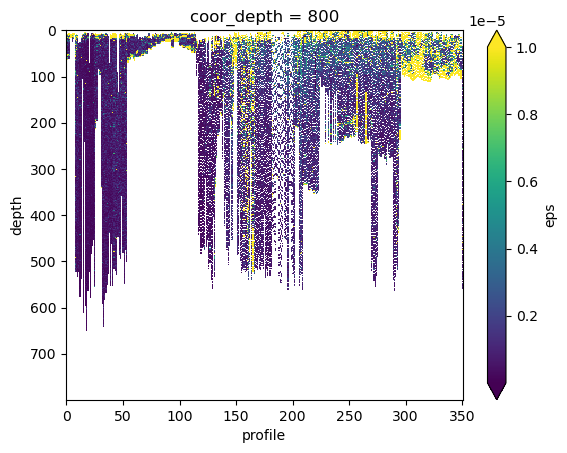

In [194]:
# plot the eps variable with transposed coordinates
ds_transposed.eps.plot(vmin= 1e-9, vmax = 1e-5, cmap='viridis')

# add axis labels
plt.xlabel("profile")
plt.ylabel("depth")
plt.gca().invert_yaxis()

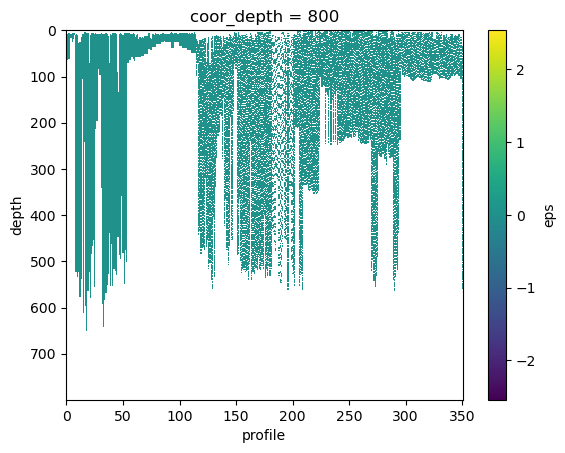

In [189]:
# plot the eps variable with transposed coordinates
ds_transposed.eps.plot(cmap='viridis')

# add axis labels
plt.xlabel("profile")
plt.ylabel("depth")
plt.gca().invert_yaxis()

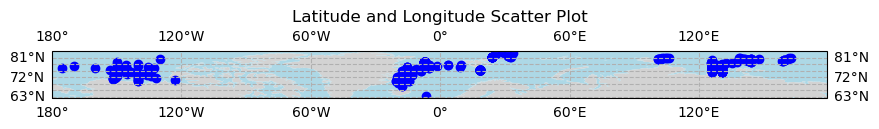

In [157]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Assuming your dataset is stored in a DataFrame called 'data'
latitude = ds['latitude']
longitude = ds['longitude']

# Create a figure and axes with a specific projection
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Add land and ocean features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot latitude and longitude data as scatter points
ax.scatter(longitude, latitude, color='blue', marker='o', transform=ccrs.PlateCarree())

# Add gridlines
ax.gridlines(draw_labels=True, linestyle='--')

# Set plot title and labels
plt.title('Latitude and Longitude Scatter Plot')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()


## Change time format (don't run if manual)

In [15]:
import datetime
import numpy as np
import xarray as xr

# Assuming `ds.year` contains a single value of 2007
year = ds.year.item()

# Define a function to convert time values to UTC
def convert_to_utc(time_value):
    if np.isnan(time_value):
        return np.nan
    day_of_year = int(time_value)
    fraction = time_value % 1
    dt = datetime.datetime(year, 1, 1) + datetime.timedelta(days=day_of_year - 1) + datetime.timedelta(days=fraction)
    return dt

# Apply the function to the 'time' variable in the dataset
convert_to_utc_vec = np.vectorize(convert_to_utc)
ds['UTCtime'] = xr.apply_ufunc(convert_to_utc_vec, ds.time)
ds["time"] = ds["UTCtime"]

## Change format to fit required format in load_ds

In [238]:
# create a transposed dataset for the next processing steps
ds = combined_dataset
# Convert depth (z) to pressure using gsw.p_from_z
ds["P"] = gsw.p_from_z(ds["depth"], ds["latitude"])

ds_final = ds.transpose("depth", "profile")

In [239]:
log_eps = np.vectorize(safe_log)(ds_final["eps"])
ds_final["log_eps"] = xr.DataArray(log_eps, dims=("depth", "profile"))

In [240]:
ds_final = ds_final.rename({'latitude': 'latitude_var'})
ds_final["latitude"] = ds_final["latitude_var"]

ds_final = ds_final.rename({'longitude': 'longitude_var'})
ds_final["longitude"] = ds_final["longitude_var"]

## Save file

In [241]:
# Construct the file path using the parent directory
file_path = os.path.join(parent_dir, "data", "interim", "ASBO-TEACOSI_ds.nc")
ds_final.to_netcdf(file_path)

# Random plots

# it's not clear whether we should use smoothed N^2 here

#plt.plot(ds2.kappa_sm.mean(axis=0),ds2.z)

#plt.xscale('log')

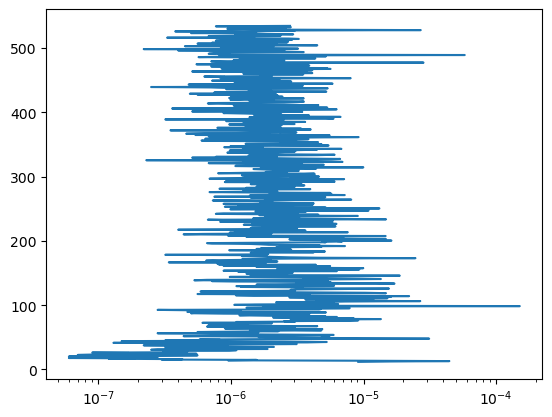

In [60]:
plt.plot(k[10],depth[10])
plt.xscale('log')

In [61]:
profiles = distinct_profiles.shape
profiles

(351,)

In [20]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

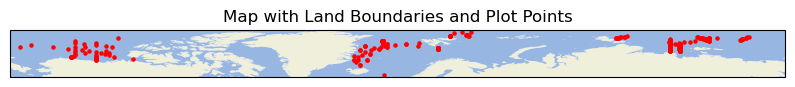

In [21]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.scatter(lon_profiles, lat_profiles, transform=ccrs.PlateCarree(), color='red', s=5)

# Add land, ocean, and borders
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))

#ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.set_title("Map with Land Boundaries and Plot Points")
plt.show()

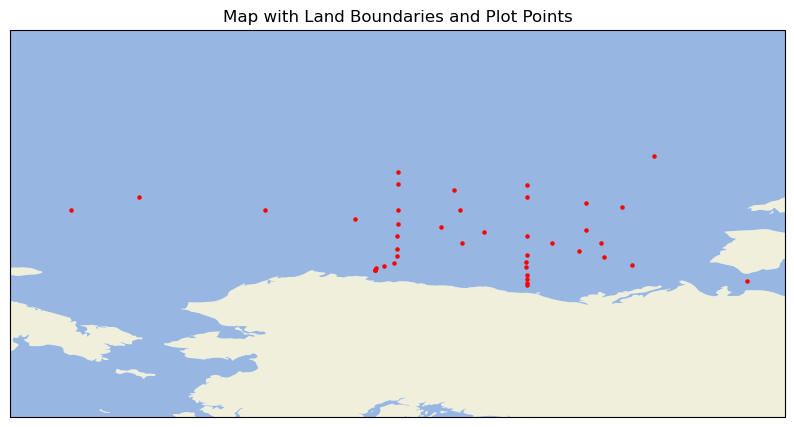

In [24]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.scatter(lon_profiles, lat_profiles, transform=ccrs.PlateCarree(), color='red', s=5)

# Add land, ocean, and borders
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))

ax.set_extent([-180, -120, 60, 90], crs=ccrs.PlateCarree())
ax.set_title("Map with Land Boundaries and Plot Points")
plt.show()

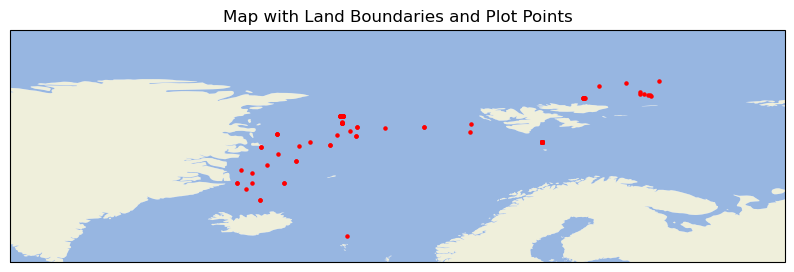

In [27]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.scatter(lon_profiles, lat_profiles, transform=ccrs.PlateCarree(), color='red', s=5)

# Add land, ocean, and borders
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))

ax.set_extent([-50, 50, 60, 90], crs=ccrs.PlateCarree())
ax.set_title("Map with Land Boundaries and Plot Points")
plt.show()

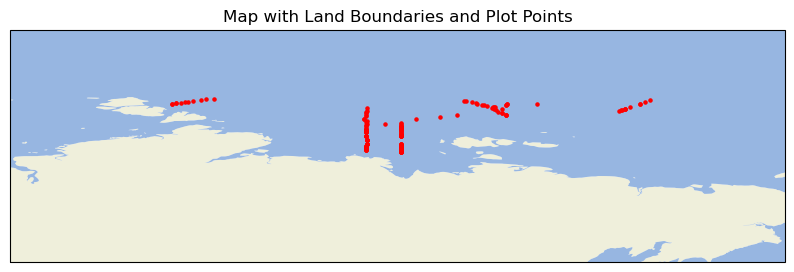

In [28]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.scatter(lon_profiles, lat_profiles, transform=ccrs.PlateCarree(), color='red', s=5)

# Add land, ocean, and borders
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))

ax.set_extent([80, 180, 60, 90], crs=ccrs.PlateCarree())
ax.set_title("Map with Land Boundaries and Plot Points")
plt.show()

In [64]:
lon_min, lon_max = np.min(lon_profiles), np.max(lon_profiles)
lat_min, lat_max = np.min(lat_profiles), np.max(lat_profiles)
lon_ticks = np.arange(np.floor(lon_min), np.ceil(lon_max), 5)
lat_ticks = np.arange(np.floor(lat_min), np.ceil(lat_max), 5)

Text(0.5, 1.0, 'Map Alberto data for ArcticMix boundaries')

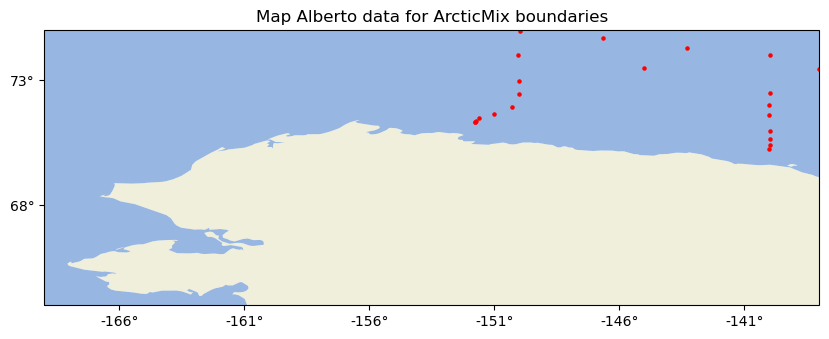

In [65]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.scatter(lon_profiles, lat_profiles, transform=ccrs.PlateCarree(), color='red', s=5)

# Add land, ocean, and borders
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))

ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
ax.set_xticklabels([f"{tick:.0f}°" for tick in lon_ticks])
ax.set_yticklabels([f"{tick:.0f}°" for tick in lat_ticks])

ax.set_extent([-169, -138, 64, 75], crs=ccrs.PlateCarree())
#ax.set_extent([-180, -130, -90, 90], crs=ccrs.PlateCarree())
ax.set_title("Map Alberto data for ArcticMix boundaries")


#plt.show()

## Statistical analysis between eps1 and eps2 
Which one should be used in the final dataframe?

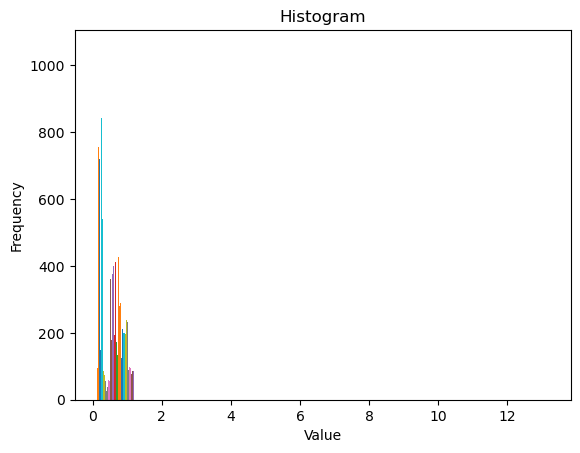

In [37]:
plt.hist(eps.ravel())

# Set the axis labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

# Show the plot
plt.show()

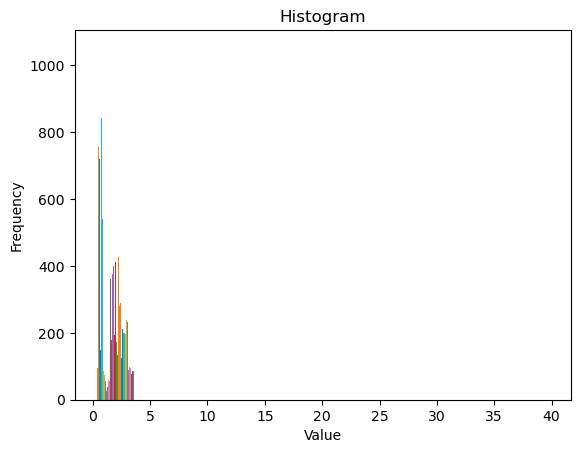

In [38]:
plt.hist(eps2.ravel())

# Set the axis labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

# Show the plot
plt.show()

In [39]:
# concatenate nested arrays into a single array
cat_eps = np.concatenate(eps)
flat_arr1 = cat_eps
flat_arr2 = np.concatenate(eps2)

In [40]:
from scipy.stats import describe
arr1_mean, arr1_var, arr1_std = describe(flat_arr1)[2:5]
print("eps1 mean:", arr1_mean)
print("eps1 variance:", arr1_var)
print("eps1 std:", arr1_std)

eps1 mean: 0.0009533740680055606
eps1 variance: 0.0037184156960205633
eps1 std: 183.54571806111147


In [41]:
from scipy.stats import describe
arr2_mean, arr2_var, arr2_std = describe(flat_arr2)[2:5]
print("eps2 mean:", arr2_mean)
print("eps2 variance:", arr2_var)
print("eps2 std:", arr2_std)

eps2 mean: 0.0009530349163039517
eps2 variance: 0.021713181950857946
eps2 std: 244.407999722473


In [42]:
# define threshold for outliers (e.g., 3 standard deviations)
threshold = 0.1

# calculate number of outliers for each dataset
outliers1 = np.sum(np.abs(flat_arr1 - arr1_mean) > threshold * arr1_std)
outliers2 = np.sum(np.abs(flat_arr2 - arr2_mean) > threshold * arr2_std)
# print results
print(f"Dataset 1 has {outliers1} outliers out of {len(flat_arr1)} values")
print(f"Dataset 2 has {outliers2} outliers out of {len(flat_arr2)} values")

Dataset 1 has 0 outliers out of 92258 values
Dataset 2 has 1 outliers out of 92258 values


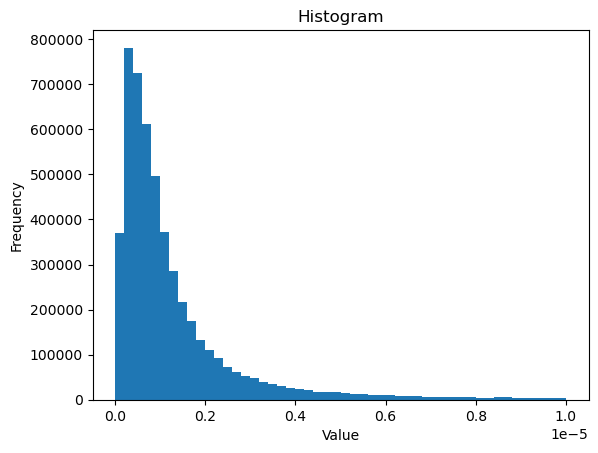

In [61]:
# Plot the histogram with adjusted parameters
plt.hist(cat_eps.ravel(), bins=50, density=True, range=(0.0000000001, 0.00001))

# Set the axis labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

# Show the plot
plt.show()


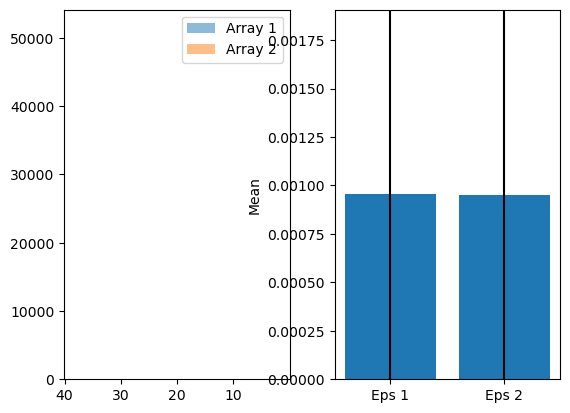

In [62]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

ax1.hist(flat_arr1.flatten(), alpha=0.5, label='Array 1', range=(0.0000000001, 0.00001))
ax1.hist(flat_arr2.flatten(), alpha=0.5, label='Array 2', range=(0.0000000001, 0.00001))
ax1.set_xlim(max(flat_arr2))
ax1.legend()

ax2.bar(['Eps 1', 'Eps 2'], [arr1_mean, arr2_mean], yerr=[arr1_std, arr2_std], capsize=10)
ax2.set_ylabel('Mean')
ax2.set_ylim([0, max(arr1_mean, arr2_mean)*2])

plt.show()